In [129]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate motors

In [130]:
def create_motors(n_motors=10, d_lims=(0,10), th_lims=(-pi,pi)):
    motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(*d_lims)).trs() * 
               vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(*th_lims) * -0.5)) 
              for i in range(n_motors)]
    return motors

# Planes

In [353]:
def rms_motor(results):
    rms_rot = []
    rms_mot = []
    rms_trs = []
    for result in results:
        (_, m, em, _) = result
        
#         rot_error = np.min([np.linalg.norm(np.array(m.rot()) - np.array(em.rot())),
#                       np.linalg.norm(np.array(m.rot()) + np.array(em.rot()))])
#         rot = np.inner(rot_error, rot_error)
        
        emm = em.rev() * m
        angle_error = 2 * np.arccos(np.abs(emm[0]))
        rot = angle_error**2
        
#         angle_error = 2 * np.arccos(np.abs(m[0])) - 2 * np.arccos(np.abs(em[0]))
        angle_error2 = 2 * np.arctan2(emm.rot().biv().norm(), emm[0])
        rot2 = angle_error2**2
    
        d1 = np.array(m.trs() - em.trs())
        trs2 = np.inner(d1,d1)
        d = emm.trs()
        trs = np.inner(d,d)
        
        rms_mot.append(trs2)
        rms_rot.append(rot)
        rms_trs.append(trs)
        
#         print('m_during: ', m)
        
#     print()
        

    motmean = np.sqrt(np.sum(rms_mot) / len(rms_mot))
#     rotmean = np.mean(rms_rot)
    rotmean = np.sqrt(np.sum(rms_rot) / len(rms_rot))
    trsmean = np.sqrt(np.sum(rms_trs) / len(rms_trs)) 
    return (motmean, rotmean, trsmean)

In [354]:
def compare_rms_motor(results, results_vd, results_tin):
    RMS = {'Ti': {}, "VD": {}, 'Ti2': {}}
    our_mot, our_rot, our_trs = rms_motor(results)
    Ti = RMS['Ti']
    Ti['mot'] = our_mot
    Ti['rot'] = our_rot
    Ti['trs'] = our_trs
    
    vd_mot, vd_rot, _ = rms_motor(results_vd)
    VD = RMS['VD']
    VD['rot'] = vd_rot
    VD['mot'] = vd_mot
    
    our_mot2, our_rot2, our_trs2 = rms_motor(results_tin)
    Ti2 = RMS['Ti2']
    Ti2['mot'] = our_mot2
    Ti2['rot'] = our_rot2
    Ti2['trs'] = our_trs2
    return pd.DataFrame(RMS)

In [355]:
def run_planes(n_planes=10, n_sets=10, n_motors=10, 
               trs_noise_std=0.0,
               rot_noise_std=0.0, 
               noisy=False):
    motors = create_motors(n_motors, d_lims=(0, 1), th_lims=(0,pi/2))
    results = []
    results_vd = []
    results_tin = []
    for n_set in range(n_sets):
        datasets = [create_random_planes(motor, n_planes, 
                                         rot_noise_std=rot_noise_std,
                                         trs_noise_std=trs_noise_std) 
                    for motor in motors]
        for dataset in datasets:
            results.append(estimate_motors_planes(dataset, noisy=noisy))
            results_vd.append(estimate_motors_planes_vd(dataset, noisy=noisy))
            results_tin.append(estimate_motors_planes(dataset, noisy=noisy, commutator=True))
    return (results, results_vd, results_tin)

In [356]:
def create_random_planes(motor, n_planes=10,
                        trs_noise_std=0.09, rot_noise_std=0.09):
    planes = []
    for i in range(n_planes):
        dir_vec = vsr.Vec(*np.random.uniform(-1,1,3)).unit()
        distance = np.random.uniform(0,1)
        a = vsr.Dlp(dir_vec,distance)
        b = a.spin(motor)
        if trs_noise_std > 0.0:
            t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,trs_noise_std,1)
        else:
            t = vsr.Vec(0,0,0)
            
        if rot_noise_std > 0.0:
            R = vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * 
                            np.random.normal(0, rot_noise_std) * -0.5)
        else:
            R = vsr.Rot(1,0,0,0)
        noise_motor = t.trs() * R
        
        bn = a.spin(noise_motor).spin(motor)
        planes.append((a,b,bn))
    return (planes, motor)

In [357]:
def estimate_motors_planes(dataset, 
                           initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                           noisy=False,
                          commutator=False):
    planes, motor = dataset
        
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in planes:
            if commutator:
                mes.add_dual_plane_commutator_residual_block(a,bn)
            else:
                mes.add_dual_plane_difference_residual_block(a,bn)
    else:
        for (a, b, _) in planes:
            if commutator:
                mes.add_dual_plane_commutator_residual_block(a,b)
            else:
                mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (planes, motor, estimated_motor, summary)

In [358]:
def estimate_motors_planes_lars(dataset, noisy=False):
    lines, motor = dataset
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
        w, v = np.linalg.eig(Lp)
        r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return vsr.Mot(*np.array([r, q]).ravel())

    Q = np.zeros((8,8))
        
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(vsr.CGA(a))
        lines_b.append(vsr.CGA(b))
        lines_bn.append(vsr.CGA(bn))
        
    if noisy:
        for b,a in zip(lines_a, lines_bn):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)
    else:
        for b,a in zip(lines_a, lines_b):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)

    estimated_motor = solve(Q)
    if np.abs((estimated_motor * estimated_motor.rev())[7])  > 0.0000000001:
        print(wrong)
              
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
        
    return (lines, motor, estimated_motor, _)

In [359]:
def estimate_motors_planes_vd(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    vd = VDMotorEstimationSolver()
    planes, motor = dataset
    planes_a = []
    planes_b = []
    planes_bn = []
    for (a,b,bn) in planes:
        planes_a.append(a)
        planes_b.append(b)
        planes_bn.append(bn)
    if noisy:
        vd.add_dual_plane_observations(planes_a, planes_bn)
    else:
        vd.add_dual_plane_observations(planes_a, planes_b)

    estimated_motor = vd.solve()
        
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
    
    return (planes, motor, estimated_motor, [])

# TRS and ROT SIM

In [393]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1,  n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)

rot_trs_noise_results = [run_planes(32,10,10,
                                      trs_noise_std=noise_level_trs,
                                      rot_noise_std=noise_level_rot,
                                      noisy=True) 
        for noise_level_rot, noise_level_trs in zip(noise_levels_rot, noise_levels_trs) ]

rmss_rot_trs_noise = [compare_rms_motor(*result) for result in rot_trs_noise_results]

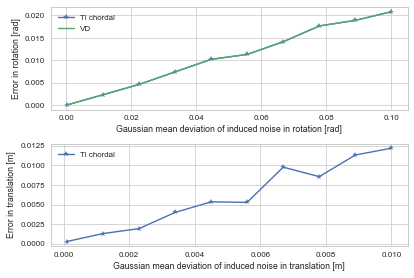

In [399]:
d = pd.concat(rmss_rot_trs_noise)
fig, ax = plt.subplots(2)

fig.subplots_adjust(hspace=.33)

ax0 = ax[0]

# ax.plot(noise_levels_rot, d['Ti2']['rot'], label='Ti commutator')
ax0.plot(noise_levels_rot, d['Ti']['rot'], marker='*', label='Ti chordal')
ax0.plot(noise_levels_rot, d['VD']['rot'], label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')
ax0.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')

# ax0.set_ylabel('Mean geometric error')
# ax0.set_xlabel('Gaussian mean deviation of induced noise')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'], marker='*', label='Ti chordal')

ax1.legend(frameon=False, loc=2)
ax1.set_xlabel('Gaussian mean deviation of induced noise in translation [m]')
ax1.set_ylabel('Error in translation [m]')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/planes-trs-rot-noise.pdf')

# ONLY ROT

In [406]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1,  n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)

rot_noise_results = [run_planes(32,10,10,
                                      trs_noise_std=0.001,
                                      rot_noise_std=noise_level_rot,
                                      noisy=True) 
        for noise_level_rot, noise_level_trs in zip(noise_levels_rot, noise_levels_trs) ]

rmss_rot_noise = [compare_rms_motor(*result) for result in rot_noise_results]

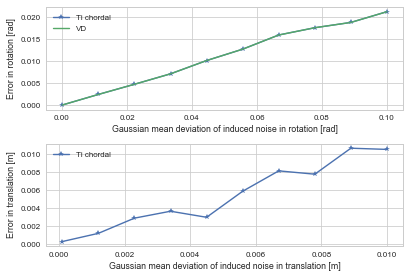

In [407]:
d = pd.concat(rmss_rot_noise)

fig, ax = plt.subplots(2)

fig.subplots_adjust(hspace=.33)

ax0 = ax[0]

# ax.plot(noise_levels_rot, d['Ti2']['rot'], label='Ti commutator')
ax0.plot(noise_levels_rot, d['Ti']['rot'], marker='*', label='Ti chordal')
ax0.plot(noise_levels_rot, d['VD']['rot'], label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')
ax0.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')

# ax0.set_ylabel('Mean geometric error')
# ax0.set_xlabel('Gaussian mean deviation of induced noise')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'], marker='*', label='Ti chordal')

ax1.legend(frameon=False, loc=2)
ax1.set_xlabel('Gaussian mean deviation of induced noise in translation [m]')
ax1.set_ylabel('Error in translation [m]')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/planes-rot-noise.pdf')

# ONLY TRS

In [412]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1,  n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)

trs_noise_results = [run_planes(32,10,10,
                                      trs_noise_std=noise_level_trs,
                                      rot_noise_std=0.001,
                                      noisy=True) 
        for noise_level_rot, noise_level_trs in zip(noise_levels_rot, noise_levels_trs) ]

rmss_trs_noise = [compare_rms_motor(*result) for result in trs_noise_results]

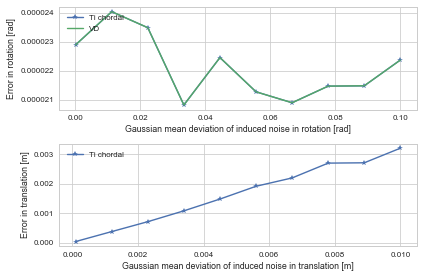

In [411]:
d = pd.concat(rmss_trs_noise)

fig, ax = plt.subplots(2)

fig.subplots_adjust(hspace=.33)

ax0 = ax[0]

# ax.plot(noise_levels_rot, d['Ti2']['rot'], label='Ti commutator')
ax0.plot(noise_levels_rot, d['Ti']['rot'], marker='*', label='Ti chordal')
ax0.plot(noise_levels_rot, d['VD']['rot'], label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')
ax0.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')

# ax0.set_ylabel('Mean geometric error')
# ax0.set_xlabel('Gaussian mean deviation of induced noise')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'], marker='*', label='Ti chordal')

ax1.legend(frameon=False, loc=2)
ax1.set_xlabel('Gaussian mean deviation of induced noise in translation [m]')
ax1.set_ylabel('Error in translation [m]')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/planes-trs-noise.pdf')

In [413]:
def analyze_iterations(results):
    summaries = [result[3] for result in results]
    iteration_numbers = []
    for summary in summaries:
        iteration_numbers.append(len(pd.DataFrame(summary['iterations'])['cost']))
        
#     median = np.median(iteration_numbers)
#     argmedian = np.where([iteration_numbers == median])[1][0]
#     median_costs = pd.DataFrame(summaries[argmedian]['iterations'])['cost']
#     median_gradients = pd.DataFrame(summaries[argmedian]['iterations'])['gradient_max_norm']

    
    argmax = np.argmax(iteration_numbers)
    max_ = np.max(iteration_numbers)
    max_costs = pd.DataFrame(summaries[argmax]['iterations'])['cost']
    max_gradients = pd.DataFrame(summaries[argmax]['iterations'])['gradient_max_norm']

    
    argmin = np.argmin(iteration_numbers)
    min_ = np.min(iteration_numbers)
    min_costs = pd.DataFrame(summaries[argmin]['iterations'])['cost']
    min_gradients = pd.DataFrame(summaries[argmin]['iterations'])['gradient_max_norm']
    return ((max_, argmax, max_costs, max_gradients), 
            (min_, argmin, min_costs, min_gradients))

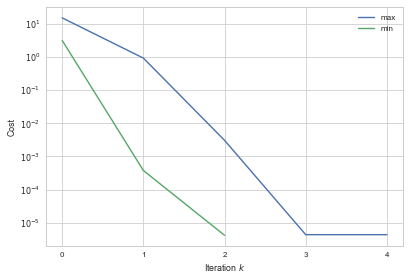

In [415]:
fig, ax = plt.subplots(1)
max_, min_ = analyze_iterations(rot_trs_noise_results[0][0])
ax0 = ax
ax0.semilogy(max_[2], label='max')
ax0.semilogy(min_[2], label='min')
ax0.legend(frameon=False, loc=1)
ax0.set_ylabel('Cost')
ax0.set_xlabel('Iteration $k$')
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.subplots_adjust(hspace=0.5)


plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/planes-iterations-rot-trs-noise.pdf')

# Translation invariance

In [367]:
def transform_dataset(dataset, motor):
    planes, original_motor = dataset
    transformed_planes = [(a.spin(motor), b.spin(motor), bn.spin(motor)) for a,b,bn in planes]
    transformed_motor = vsr.CGA(original_motor).spin(vsr.CGA(motor)).mot()
    return (transformed_planes, transformed_motor)
    
n_motors = 10
d_lims = (0,2)
th_lims = (0,pi)
motors = create_motors(n_motors, d_lims=d_lims, th_lims=th_lims)
motors2 = create_motors(n_motors, d_lims=d_lims, th_lims=th_lims)

dataset = create_random_planes(motors[0], 3, 
                                    rot_noise_std=0.1, 
                                    trs_noise_std=0.01,
                                    )

_, m1, em1 , _ = estimate_motors_planes(dataset, noisy=True)
_, m2, em2 , _ = estimate_motors_planes(transform_dataset(dataset, motors2[0]), noisy=True)

print(em1)
print(em2)

em1_t = vsr.CGA(em1).spin(vsr.CGA(motors2[0])).mot()
print(em1_t)

Mot: [ 0.81 -0.11 -0.051 -0.57 0.068 -0.71 -0.13 -0.075 ]
Mot: [ 0.81 -0.11 -0.41 -0.4 -0.44 -0.43 0.54 -0.081 ]
Mot: [ 0.81 -0.11 -0.41 -0.4 -0.44 -0.43 0.53 -0.075 ]
